![Clase aprendizaje no supervisado](https://raw.githubusercontent.com/MECA4605-Aprendizaje-no-supervisado/taller_4/main/figs/taller-meca-aprendizaje%20no%20supervisado_banner%201169%20x%20200%20px%20-05.png)

# Caso-taller:  Analizando el Delito en Chicago

En este caso-taller vamos a utilizar datos geográficos y estimación de densidad de kernel para analizar delitos en Chicago. Esta ciudad es muy famosa no sólo por haber sido el hogar del mafioso Al Capone, sino también por sus altas tasas de delitos.

Para este taller obtuve datos del portal de la [ciudad de Chicago](https://www.chicago.gov/city/en/dataset/crime.html). La base de datos fue traducida y modificada para nuestras necesidades. Esta contiene todos los homicidios y robos que sucedieron entre el 1 de junio y el 31 de agosto de 2019.


## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "entrega calificada por el personal".

4. El archivo entregado debe poder ser ejecutado localmente por el tutor. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos en el mismo `path` de su cuaderno, por ejemplo: `data`.

## Desarrollo


### 1.Carga de datos

#### 1.1. Delitos

En la carpeta `data` se encuentra el archivo `Chicago_delitos_verano_2019.csv` cargue estos datos en su *cuaderno*. Describa brevemente el contenido de la base.

In [9]:
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter("ignore")
from sklearn.datasets import make_blobs
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
chicago = pd.read_csv('https://raw.githubusercontent.com/sebastian23escobar/Aprendizaje_no_supervisado/refs/heads/main/Taller4/data/Chicago_delitos_verano_2019.csv')
chicago

,fecha,tipo_crimen,nro_area_comunitaria,lat,lon
0,2019-06-01T05:07:00Z,homicidio,23,41.897950,-87.728625
1,2019-06-01T10:09:00Z,homicidio,71,41.753272,-87.648963
2,2019-06-01T12:46:00Z,homicidio,25,41.877622,-87.750728
3,2019-06-01T11:35:00Z,homicidio,16,41.960145,-87.699654
4,2019-06-02T09:39:00Z,homicidio,37,41.804773,-87.633256
...,...,...,...,...,...
17742,2019-08-20T18:00:00Z,robo,77,41.980874,-87.659992
17743,2019-06-20T17:00:00Z,robo,77,41.987182,-87.666804
17744,2019-08-01T05:01:00Z,robo,25,41.890446,-87.757887
17745,2019-08-19T05:01:00Z,robo,8,41.904537,-87.634504


In [3]:
chicago.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17747 entries, 0 to 17746
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fecha                 17747 non-null  object 
 1   tipo_crimen           17747 non-null  object 
 2   nro_area_comunitaria  17747 non-null  int64  
 3   lat                   17747 non-null  float64
 4   lon                   17747 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 693.4+ KB


In [6]:
# convertir fecha a formato fecha
chicago['fecha'] = pd.to_datetime(chicago['fecha'])

In [7]:
chicago['tipo_crimen'].unique()

array(['homicidio', 'robo'], dtype=object)

In [17]:
# crear una serie de tiempo
serie_tiempo = chicago.groupby(['fecha', 'tipo_crimen']).size().reset_index(name = 'conteo')

# filtrar serie de tiempo por robos
robos = serie_tiempo[serie_tiempo['tipo_crimen'] == 'robo']
# filtrar serie de tiempo por homicidios
homicidios = serie_tiempo[serie_tiempo['tipo_crimen'] == 'homicidio']

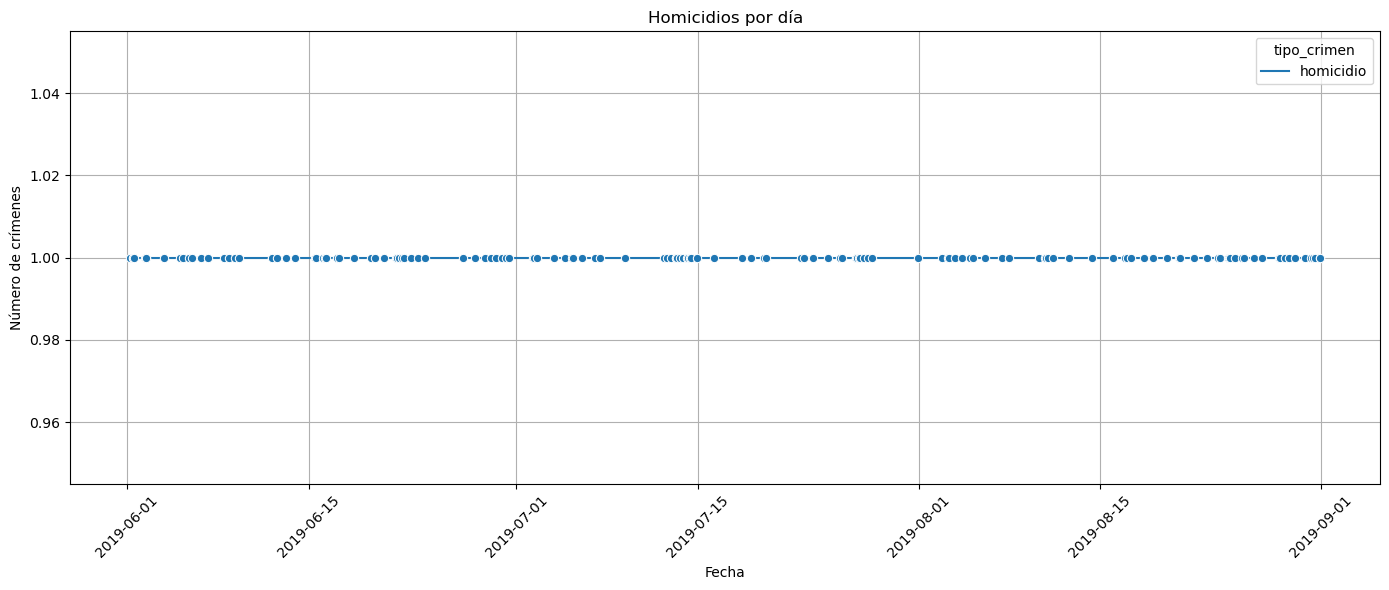

In [18]:
plt.figure(figsize = (14,6))
sns.lineplot(data = homicidios, x = 'fecha', y = 'conteo', hue = 'tipo_crimen', marker = 'o')
plt.title('Homicidios por día')
plt.xlabel('Fecha')
plt.ylabel('Número de crímenes')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.grid(True)
plt.show()

In [23]:
homicidios['conteo'].describe()

count    144.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: conteo, dtype: float64

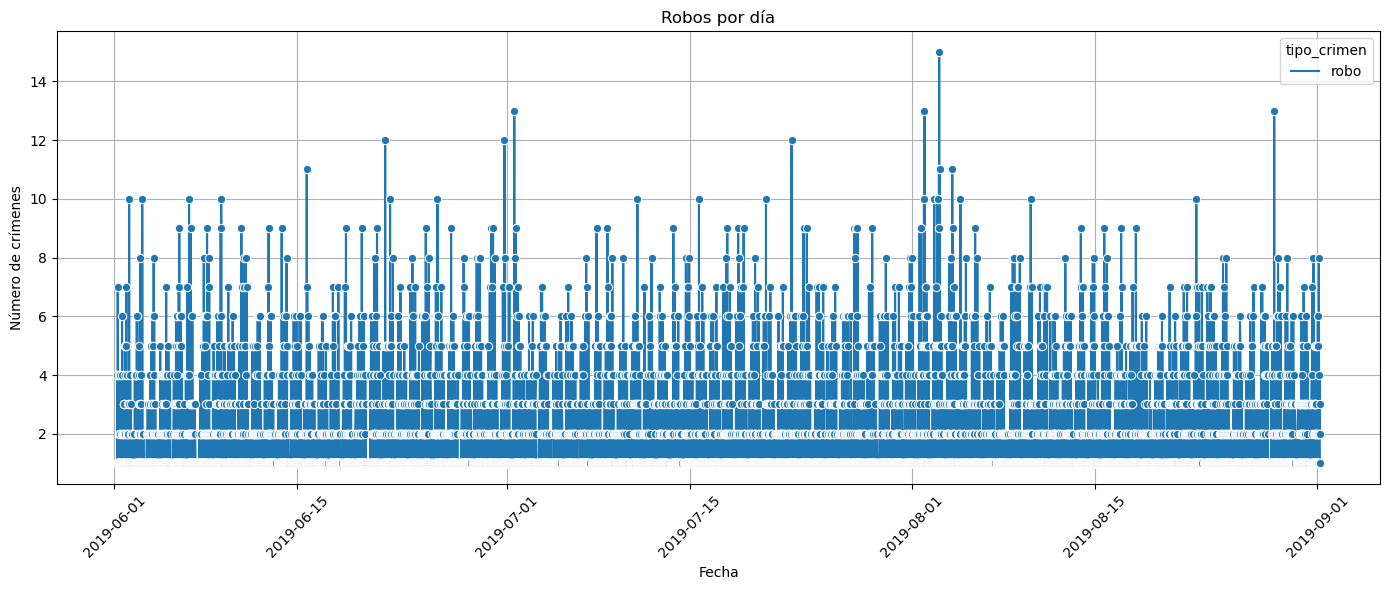

In [19]:
plt.figure(figsize = (14,6))
sns.lineplot(data = robos, x = 'fecha', y = 'conteo', hue = 'tipo_crimen', marker = 'o')
plt.title('Robos por día')
plt.xlabel('Fecha')
plt.ylabel('Número de crímenes')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.grid(True)
plt.show()

In [24]:
robos['conteo'].describe()

count    10088.000000
mean         1.744944
std          1.490286
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         15.000000
Name: conteo, dtype: float64

In [32]:
print(len(robos))
print(len(homicidios))

10088
144


A partir de los datos encontramos que los homicidios tienen una frecuencia máxima de 1 y es posible apreciar, por la gráfica, que este tipo de delitos es recurrente en la ciudad. Concretamente, los datos describen 144 homicidios. Por su parte, los tobos son un delito más común que, en nuestros datos, ha tenido un máximo histórico de 15 robos en un día en 1088 observaciones díarias.

#### 1.2. Barrios de Chicago

También en la carpeta `data` se encuentran los archivos con los polígonos de las áreas comunitarias en un archivo comprimido llamado `Areas_comunitarias_Chicago.zip`. Genere un mapa interactivo con un popup con el nombre del area comunitaria.

In [ ]:
# Utilice este espacio para escribir el código.

(Utilice este espacio para describir su procedimiento).

### 2.   Análisis distribución del crimen por barrios

#### 2.1.  Genere una tabla descriptiva donde se muestra el número total de delitos, el número total de robos y el número total de homicidios, y como porcentaje de total por barrios. La tabla debe contener ademas una fila final donde se muestre el total para la ciudad. Describa los resultados que obtiene.


In [ ]:
# Utilice este espacio para escribir el código.

(Utilice este espacio para describir el procedimiento, análisis, y conclusiones)

#### 2.2. Genere una gráfica de dispersión entre el total de homicidios y robos por barrios. Incluya en la gráfica la recta de regresión que mejor ajusta a esos datos. Describa los resultados que obtiene.

In [ ]:
# Utilice este espacio para escribir el código.

(Utilice este espacio para describir el procedimiento, análisis, y conclusiones)

### 3. Distribución espacial del delito

#### 3.1 Distribución respecto al centro de la ciudad

Tomando como centro de la ciudad las coordenadas (-87.627800, 41.881998), estime funciones de densidad que muestren gráficamente el gradiente del total de robos, y homicidios, como función de la distancia al centro de la ciudad. Explique cómo midió las distancias incluyendo que medida de distancia utilizó. Para elegir el ancho de banda y la función de kernel más apropiados utilice validación cruzada usando todas las opciones posibles de kernel. Describa los resultados que obtiene.

In [ ]:
# Utilice este espacio para escribir el código.

(Utilice este espacio para describir el procedimiento, análisis, y conclusiones)

### 3.2 Puntos calientes en la ciudad

Usando `statsmodels` implemente la estimación de densidad bivariada para el total de robos y el total de homicidios. Muestre los resultados usando curvas de nivel en una visualización interactiva. Compare los resultados de estimar usando los anchos de banda: `normal_reference` y `cv_ml`. Explique en que consisten ambas formas de estimar el ancho de banda. Comente sobre los puntos calientes encontrados bajo ambos métodos y su ubicación en la ciudad. (Esto puede tomar mucho tiempo y requerir mucha capacidad computacional, puede aprovechar los recursos de [Google Colab](https://colab.research.google.com/))

In [ ]:
# Utilice este espacio para escribir el código.

(Utilice este espacio para describir el procedimiento, análisis, y conclusiones)

## 4. Explicando la ubicación del delito

El objetivo de este punto es encontrar posibles correlaciones  entre el crimen y características de la ciudad. Para ello, utilice los datos de OpenStreetMap y explore si existe una correlación entre el porcentaje del área de la comunidad  dedicado a tiendas (`retail`)  y comercios (`commercial`) y el número total de robos y homicidios en esa comunidad. Ofrezca una explicación intuitiva de por qué cree que aparecen estas correlaciones. (Esto puede tomar mucho tiempo y requerir mucha capacidad computacional, puede aprovechar los recursos de [Google Colab](https://colab.research.google.com/))

In [ ]:
# Utilice este espacio para escribir el código.

(Utilice este espacio para describir el procedimiento, análisis, y conclusiones)